# Neutron star structure

We'll investigate neutron star structure by consider both the standard hydrostatic equilibrium:

$$\frac{dP}{dr} = - \frac{G M(r)}{r^2}$$

and the general relativistic [Tolman-Oppenheimer-Volkoff equation](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation):

$$\frac{dP}{dr} = -\frac{G}{r^2} \left (\rho + \frac{P}{c^2}\right )
    \left ( M(r) + \frac{4\pi r^3 P}{c^2} \right ) \left (1 - \frac{2 GM(r)}{rc^2} \right )$$
    
In both cases, $M(r)$ satisties:

$$\frac{dM}{dr} = 4\pi r^2 \rho$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt

Here's a general integration class that implemented 4th order Runge-Kutta.  It takes
a `rhs` function of the form:

```
rhs(r, Y)
```

that returns the derivatives $d{\bf Y}/dr$ for each of the variables in the array ${\bf Y}$.

It can also take a list of stopping criteria for each variable, so we end the integration
when we reach the edge of the star.  The integration step is fixed.

In [1]:
class Integrator:
    """ this is a simple RK4 integrator with a uniform step size
    that can accept a list of stopping criteria to halt the integration.

    There is one list element for each variable.  An entry of "None"
    means that we have no stopping criteria for that variable.  A tuple
    of the form ("LT", val) or ("GT", val), means that we stop if
    y[n] < val (or y[n] > val)
    """

    def __init__(self, rhs, *, stop_cond=None, rhs_args=None):
        self.rhs = rhs
        self.stop_cond = stop_cond
        if rhs_args is None:
            rhs_args = []
        self.args = rhs_args

    def rk4_step(self, x, y, dx):

        dydx1 = self.rhs(x, y, *self.args)
        y1 = y + 0.5*dx*dydx1
        if self.check_stop_cond(y1) < 0: return None

        dydx2 = self.rhs(x + 0.5*dx, y1, *self.args)
        y2 = y + 0.5*dx*dydx2
        if self.check_stop_cond(y2) < 0: return None

        dydx3 = self.rhs(x + 0.5*dx, y2, *self.args)
        y3 = y + dx*dydx3
        if self.check_stop_cond(y3) < 0: return None

        dydx4 = self.rhs(x + dx, y3, *self.args)

        y_final = y + (dx/6.0)*(dydx1 + 2.0*dydx2 + 2.0*dydx3 + dydx4)
        if self.check_stop_cond(y_final) < 0: return None

        return y_final

    def check_stop_cond(self, y):
        # check our stopping conditions
        if not self.stop_cond is None:
            for n, cond in enumerate(self.stop_cond):
                if cond is None: continue
                c, v = cond
                if c == "LT":
                    if y[n] < v: return -1
                elif c == "GT":
                    if ynew[n] > v: return -1
                else:
                    sys.exit("invalid condition")

        return 0

    def integrate(self, initial_conditions, dx, xmax):
        ic = np.array(initial_conditions)
        N = len(ic)
        sol = {}
        for n in range(N):
            sol[f"y{n}"] = [ic[n]]

        x = 0.0
        sol["x"] = [x]

        y = initial_conditions
        while (x < xmax):

            # advance for a step
            ynew = self.rk4_step(x, y, dx)

            if ynew is None: break

            # store the solution
            x += dx
            sol["x"].append(x)
            for n in range(N):
                sol[f"y{n}"].append(ynew[n])

            y = ynew

        return sol

Some physical constants (CGS)

In [7]:
G = 6.67e-8
c = 3.e10
h = 6.63e-27
m_u = 1.66e-24

For the TOV equation, we integrate

$${\bf Y} = (m, P)^\intercal$$

In [48]:
def rhs_tov(r, y, rho_func):
    m = y[0]
    P = y[1]

    rho = rho_func(P)
    
    dmdr = 4.0 * np.pi * r**2 * rho
        
    if r == 0.0:
        dPdr = 0.0
    else:
        rho_term = rho + P / c**2
        m_term = m + 4.0 * np.pi * r**3 * P / c**2
        metric_term = (1.0 - 2.0 * G * m / (r * c**2))
        dPdr = -(G / r**2) * rho_term * m_term / metric_term

    return np.array([dmdr, dPdr])

In [49]:
def rhs_newton(r, y, rho_func):
    m = y[0]
    P = y[1]

    rho = rho_func(P)
    
    dmdr = 4.0 * np.pi * r**2 * rho
    
    if r == 0.0:
        dPdr = 0.0
    else:
        dPdr = -G * m / r**2 * rho
        
    return np.array([dmdr, dPdr])

## Case I: Newtonian gravity, neutron degeneracy

Zero temperature neutron degeneracy

In [50]:
from scipy.optimize import brentq

def pres_deg(rho):
    # compute the Fermi momentum x = p / mc
    B = 8 * np.pi * m_u / 3.0 * (m_u * c / h)**3
    x = np.cbrt(rho / B)
    
    f = x * (2 * x**2 - 3) * np.sqrt(1 + x**2) + 3 * np.arcsinh(x)
    A = (np.pi / 3) * (m_u * c / h)**3 * m_u * c**2
    
    return A * f
    
def rho_deg(pres):
    
    A = (np.pi / 3) * (m_u * c / h)**3 * m_u * c**2
    f = pres / A
    
    # find the x that gives us this f
    x = brentq(lambda x: f - (x * (2 * x**2 - 3) * np.sqrt(1 + x**2) + 3 * np.arcsinh(x)), 0, 10)
    
    B = 8 * np.pi * m_u / 3.0 * (m_u * c / h)**3
    return B * x**3 

A stiff polytrope nuclear EOS

In [55]:
def pres_nuc(rho):
    gamma = 2.8
    K = 2.2552e-7
    
    return K * rho**gamma

def rho_nuc(pres):
    gamma = 2.8
    K = 2.2552e-7
    
    return (pres / K)**(1.0 / gamma)

In [56]:
ns1 = Integrator(rhs_newton, rhs_args=[rho_deg],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 1000

mass = []
radius = []

for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e16), 100):
    
    Pc = pres_deg(rhoc)
    
    sol = ns1.integrate([0.0, Pc], R_max/N, R_max)
    
    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)

Text(0, 0.5, 'M [solar masses]')

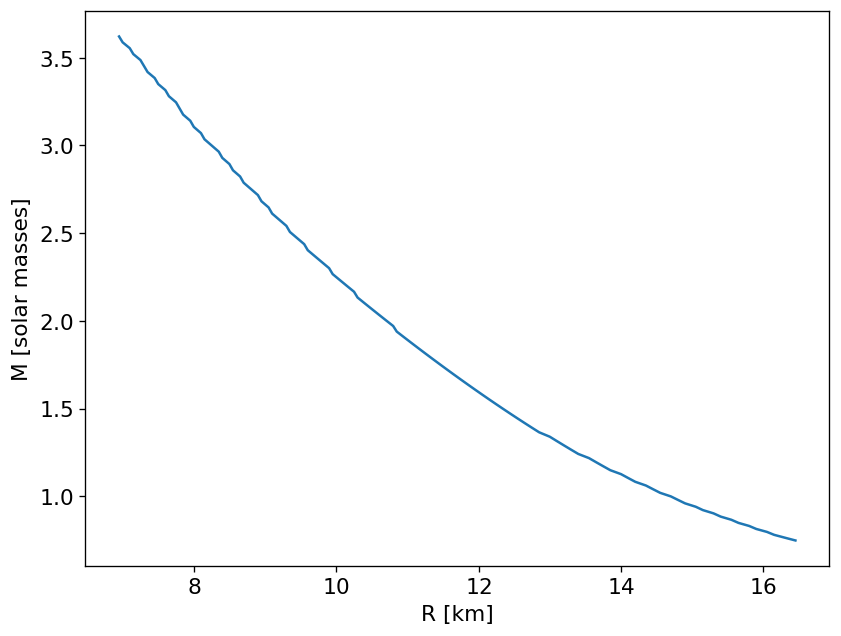

In [57]:
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("R [km]")
ax.set_ylabel("M [solar masses]")

## Case II: GR gravity + degenerate EOS

In [63]:
ns2 = Integrator(rhs_tov, rhs_args=[rho_deg],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 1000

# my vector is [m, p]
mass = []
radius = []
for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e16), 100):

    Pc = pres_deg(rhoc)

    sol = ns2.integrate([0.0, Pc], R_max/N, R_max)

    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)

Text(0, 0.5, 'M [solar masses]')

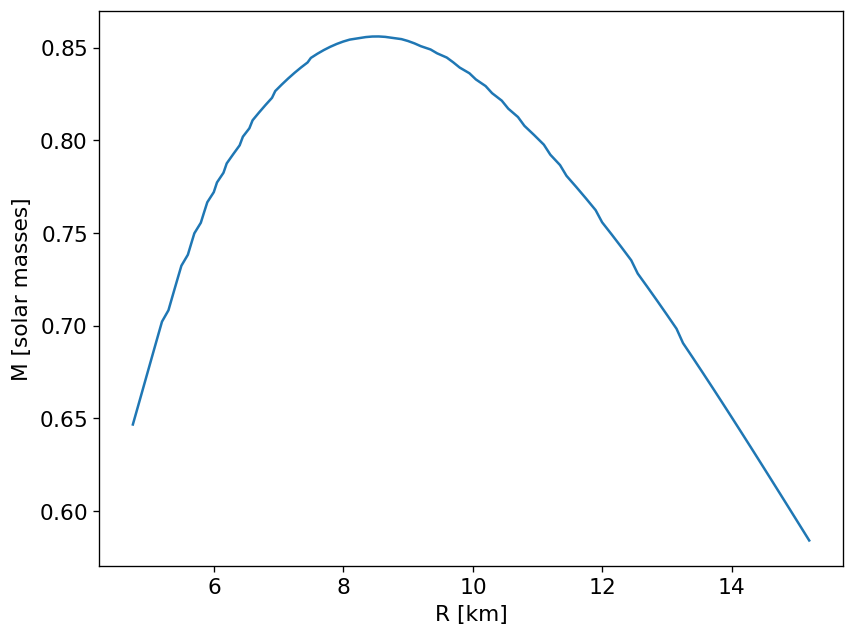

In [65]:
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("R [km]")
ax.set_ylabel("M [solar masses]")